In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

![W&B](https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67)

Use W&B to build better models faster. Track and visualize all the pieces of your machine learning pipeline, from datasets to production models.

Quickly identify model regressions. Use W&B to visualize results in real time, all in a central dashboard.
Focus on the interesting ML. Spend less time manually tracking results in spreadsheets and text files.
Capture dataset versions with W&B Artifacts to identify how changing data affects your resulting models.
Reproduce any model, with saved code, hyperparameters, launch commands, input data, and resulting model weights.


In [ ]:
# From: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024 ** 2
    print("Memory usage of properties dataframe is :", start_mem_usg, " MB")
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            IsInt = False

            mx = props[col].max()
            mn = props[col].min()

            if not np.isfinite(props[col]).all():
                props[col].fillna(-999, inplace=True)

            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()

            if -0.01 < result < 0.01:
                IsInt = True

            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)
            else:
                props[col] = props[col].astype(np.float32)

    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024 ** 2
    print("Memory usage is: ", mem_usg, " MB")
    print("This is ", 100 * mem_usg / start_mem_usg, "% of the initial size")
    return props

def load_csv(path):
    return reduce_mem_usage(pd.read_csv(path))

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("api_key")
! wandb login $secret_value_0

# Try Linear Regression , Ridge using W&B 

In [ ]:
!pip install wandb -qq
#from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pandas as pd
import wandb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection  import GridSearchCV, RandomizedSearchCV

# Load data
train = load_csv('../input/tabular-playground-series-dec-2021/train.csv')
test = load_csv('../input/tabular-playground-series-dec-2021/test.csv')

# predictor
X = train.drop(columns=['Cover_Type'])

# target
y = train['Cover_Type']

# test data 
#test = test.drop(columns=['Id'])

wandb.init(project="sklearn")
# Setting parameters

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=123, shuffle =True)

# Train model, get predictions
reg = Ridge()
reg.fit(X, y)
y_pred = reg.predict(X_val)

# Visualize all regression plots
wandb.sklearn.plot_regressor(reg, X_train, X_val, y_train, y_val, 'Ridge')

# Make individual plots
wandb.sklearn.plot_outlier_candidates(reg, X, y)

## Some Weights & Biases Metrics from Dashboard
## Output Screenshots
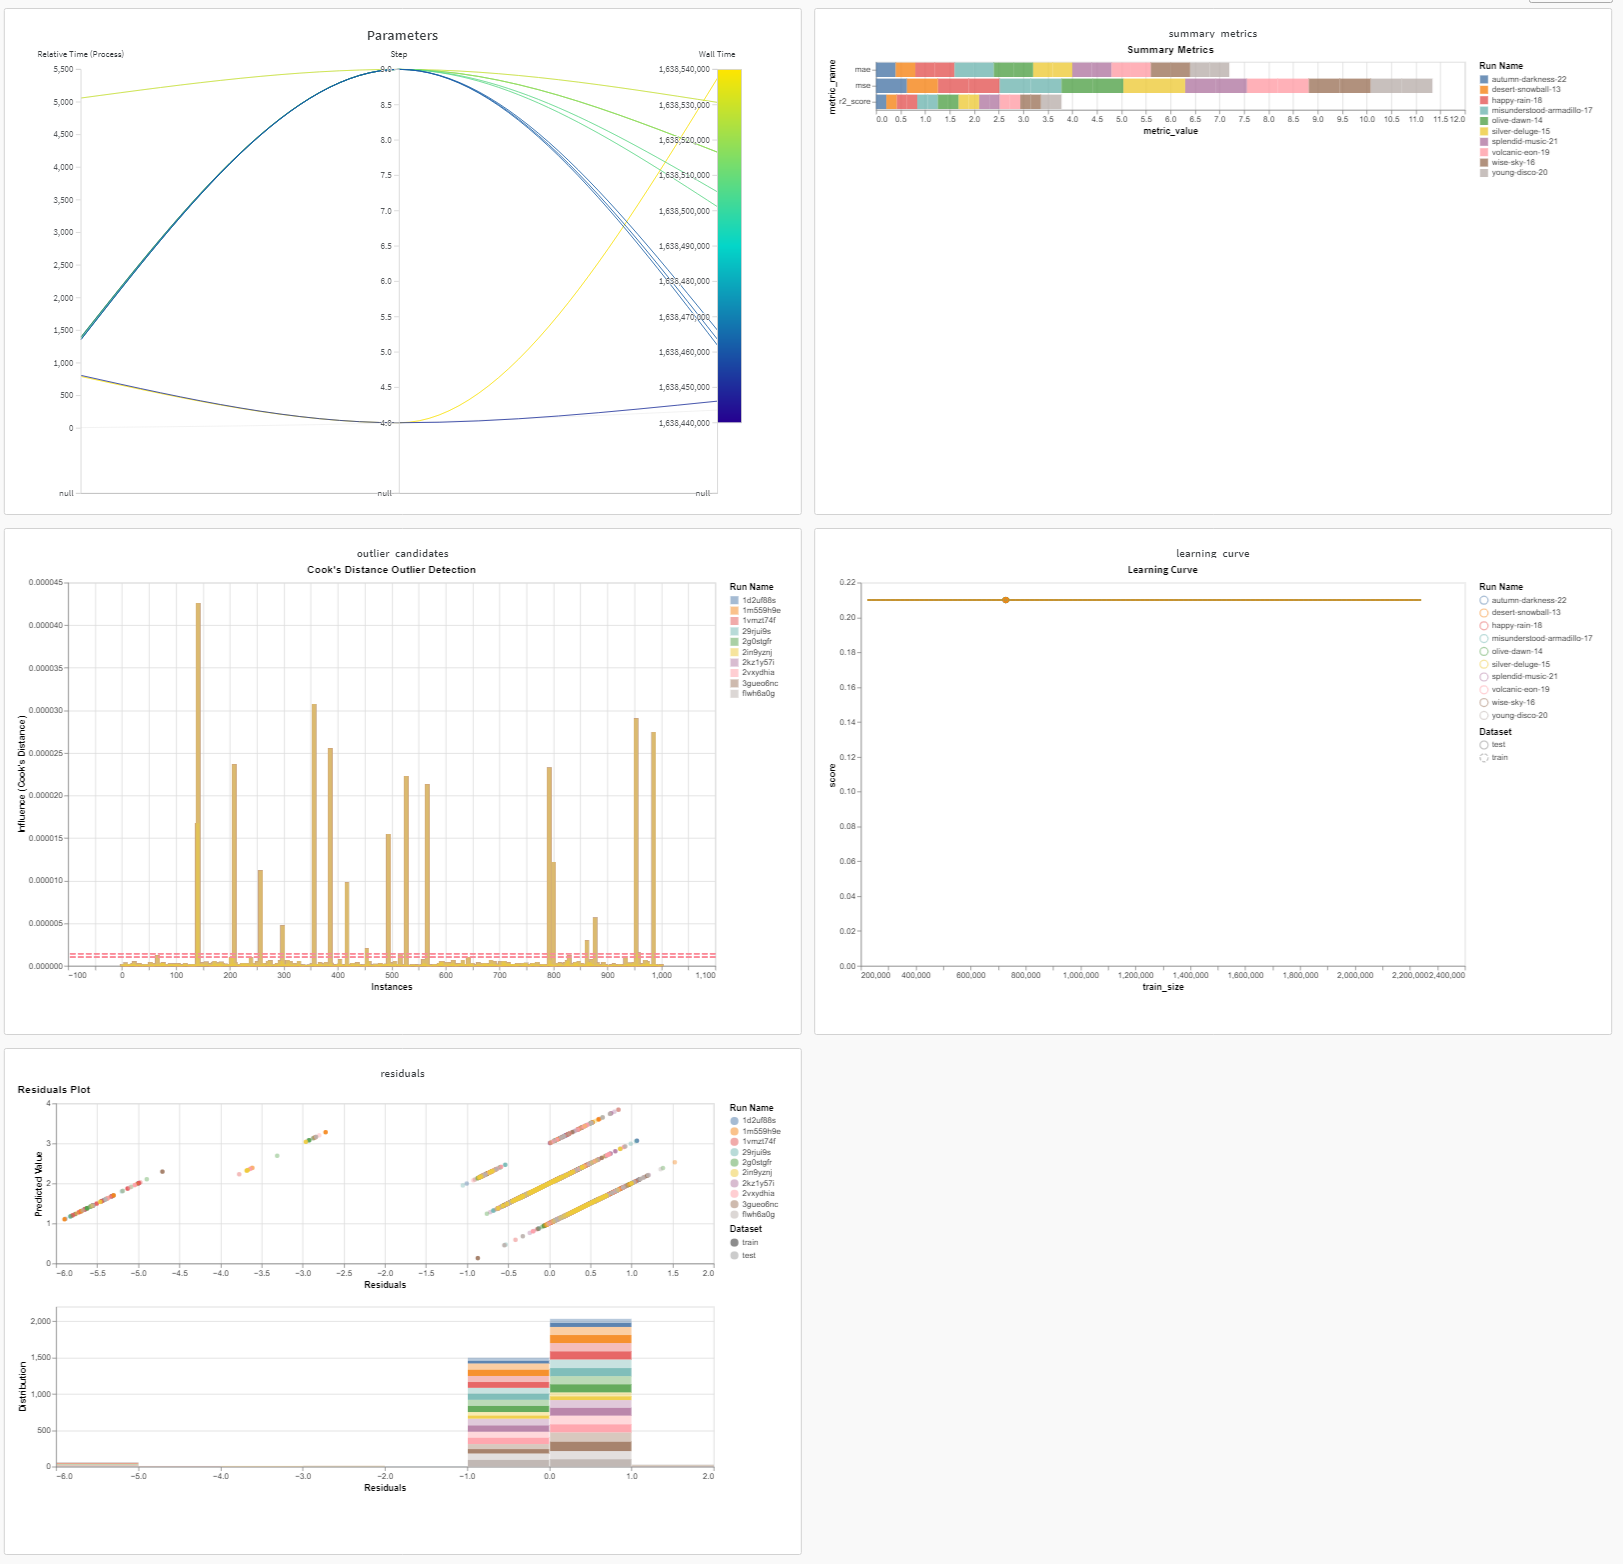
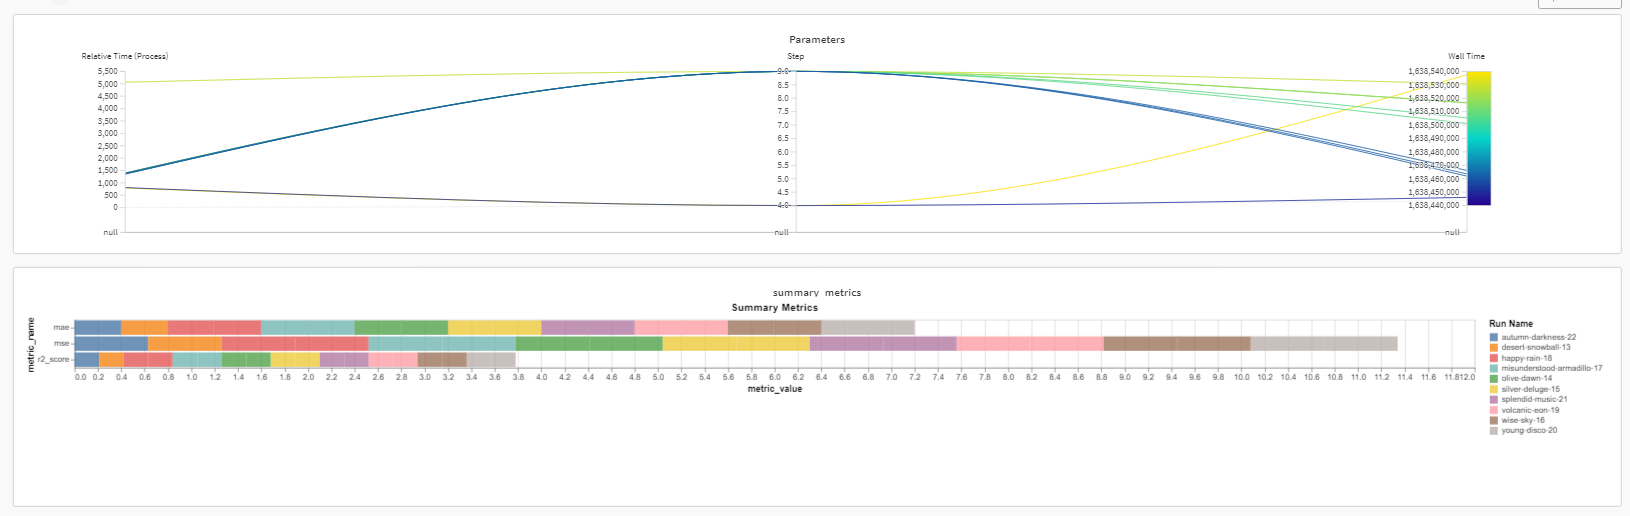
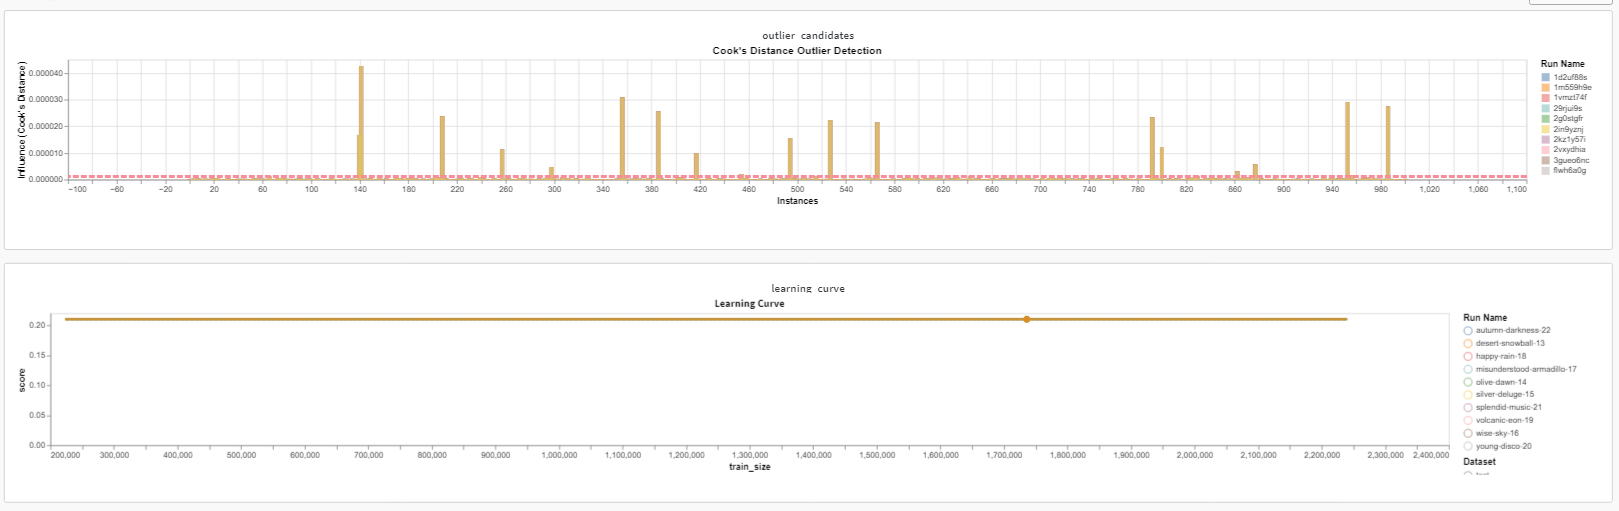
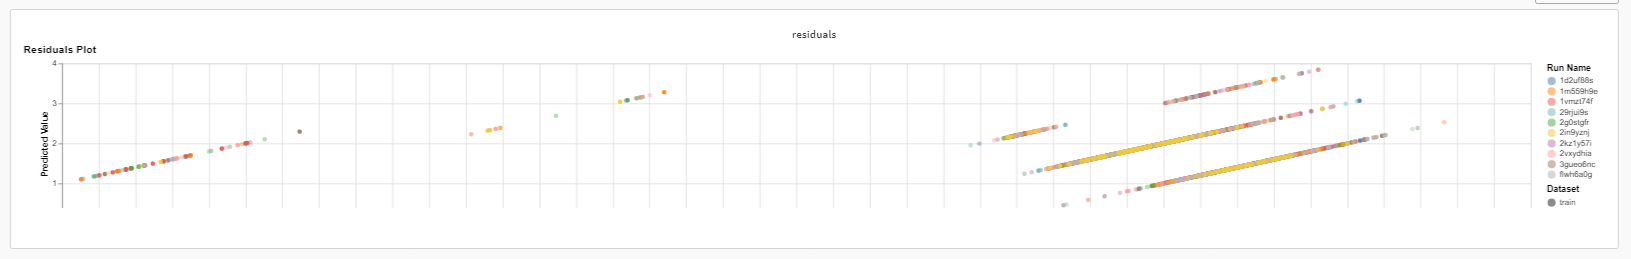

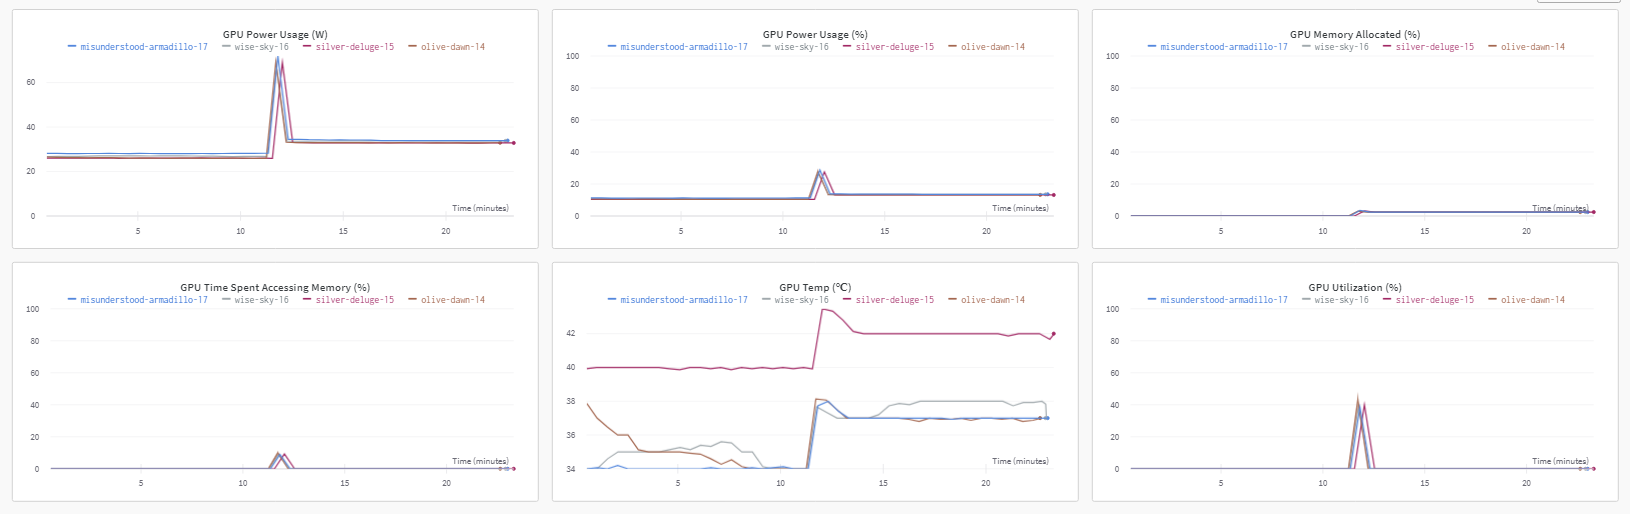

# Try XGB Classifier using Weights & Biases 

In [ ]:
#from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=123, shuffle =True)

model = XGBClassifier(learning_rate=0.3, 
                      #tree_method='gpu_hist', 
                      random_state=0)
model.fit(X_train,y_train)

# Visualize all regression plots
wandb.sklearn.plot_regressor(reg, X_train, X_val, y_train, y_val, 'XGB Classifier')

# Make individual plots
wandb.sklearn.plot_outlier_candidates(reg, X, y)

In [ ]:
# validation accuracy
#from sklearn.metrics import accuracy_score
#print('Accuracy Score : ',accuracy_score(y_val, y_pred))

In [ ]:
# test prediction
y_pred = model.predict(test)


In [ ]:
# submission
submission = pd.read_csv('../input/tabular-playground-series-dec-2021/sample_submission.csv')
submission['Cover_Type'] = y_pred
submission.to_csv("submission.csv",index=False)
submission.head()

In [ ]:
import wandb
run = wandb.init()
artifact = run.use_artifact('krahman/sklearn/run-3gueo6nc-summary_metrics:v0', type='run_table')
artifact_dir = artifact.download()

# Let us see LazyPredict for analysis

In [ ]:
try:
    import lazypredict
except:
    !pip install lazypredict
    import lazypredict
    

In [ ]:
from lazypredict.Supervised import LazyClassifier
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, shuffle =True)

In [ ]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
train,test = clf.fit(X_train, X_val, y_train, y_val)

In [ ]:
train

In [ ]:
test

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=train.index, y="Accuracy", data=train)
plt.xticks(rotation=90)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=train.index, x="Accuracy", data=train)

In [ ]:
from lazypredict.Supervised import LazyRegressor
from sklearn.utils import shuffle


In [ ]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state =42)

# Defines and builds the lazyclassifier
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)
models_train,predictions_train = reg.fit(X_train, X_train, y_train, y_train)
models_test,predictions_test = reg.fit(X_train, X_test, y_train, y_test)

# Prints the model performance
models_train

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

models_train["R-Squared"] = [0 if i < 0 else i for i in models_train.iloc[:,0] ]

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=models_train.index, x="R-Squared", data=models_train)
ax.set(xlim=(0, 1))